# Consumer Complaints Classification with LSTM

This script looks into the consumer complaints from Bank of America in California. It applies LSTM on complaint classification and figures out the products consumers are not satisfied with. 

In [51]:
import pandas as pd 

data = (
    pd.read_excel('consumer complaints BOA_CA.xlsx')
    .filter(['product','consumer_complaint_narrative'])
    .dropna()
    .set_axis(['product', 'complaint'], axis=1, inplace=False)
    .reset_index(drop=True))

data.head()

,product,complaint
0,Mortgage,I Want to file a complaint about Bank of Ameri...
1,Mortgage,I got behind in payments and worked with B of ...
2,Bank account or service,"This bank of america, gave all my money withou..."
3,Bank account or service,I have made many mistakes when I was younger a...
4,Bank account or service,I refinanced my home and chose to preserve my ...


## Complaint Labels

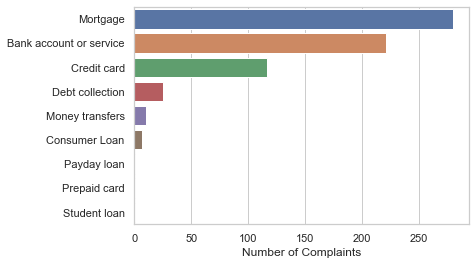

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
ax = sns.countplot(y = "product", data = data, order = data['product'].value_counts().index)
ax.set(xlabel = 'Number of Complaints', ylabel = '')
plt.show()

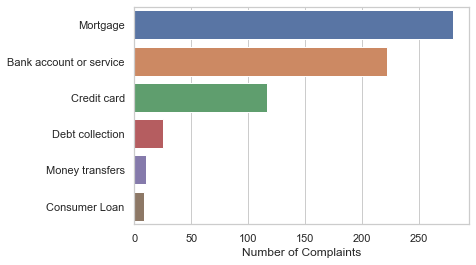

In [53]:
data['product'] = data['product'].replace({
    'Payday loan': 'Consumer Loan',
    'Student loan': 'Consumer Loan',
    'Prepaid card': 'Bank account or service'
})

sns.set_style("whitegrid")
ax = sns.countplot(y = "product", data = data, order = data['product'].value_counts().index)
ax.set(xlabel = 'Number of Complaints', ylabel = '')
plt.show()

## Text Pre-processing

1. lower case
2. remove punctuations
3. tokenize to index.... 


In [54]:
df = data

In [55]:
def clean_narrative(sample):
    """
    function to clean consumer complaint narratives 
        sample: one complaint narrative 
        return: narrative after clean   
    """
    sample = sample.lower()
    sample = sample.translate({ord(c): "" for c in "[xx!@#$%^&*()[]{};:'\/\n<>?\|`~-=_+.,\"]"})
    return sample

In [57]:
df['complaint'] = df['complaint'].apply(clean_narrative)

df.head()

,product,complaint
0,Mortgage,i want to file a complaint about bank of ameri...
1,Mortgage,i got behind in payments and worked with b of ...
2,Bank account or service,this bank of america gave all my money without...
3,Bank account or service,i have made many mistakes when i was younger a...
4,Bank account or service,i refinanced my home and chose to preserve my ...


## LSTM

In [58]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_word_database = 50000
max_complaint_length = 250
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_word_database, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['complaint'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 6938 unique tokens.
Using TensorFlow backend.


In [73]:
X = tokenizer.texts_to_sequences(df['complaint'].values)
X = pad_sequences(X, maxlen = max_complaint_length)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (663, 250)


In [74]:
Y = pd.get_dummies(df['product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (663, 6)


In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(530, 250) (530, 6)
(133, 250) (133, 6)


In [82]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(max_word_database, embedding_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

In [83]:
epochs = 5
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
8/8 [==============================] - 4s 514ms/step - loss: 1.7692 - accuracy: 0.2956 - val_loss: 1.6908 - val_accuracy: 0.4340
Epoch 2/5
8/8 [==============================] - 3s 391ms/step - loss: 1.5242 - accuracy: 0.3962 - val_loss: 1.0703 - val_accuracy: 0.4151
Epoch 3/5
8/8 [==============================] - 3s 393ms/step - loss: 1.3444 - accuracy: 0.4235 - val_loss: 1.1326 - val_accuracy: 0.4151
Epoch 4/5
8/8 [==============================] - 3s 406ms/step - loss: 1.2974 - accuracy: 0.4193 - val_loss: 1.1303 - val_accuracy: 0.4151
Epoch 5/5
8/8 [==============================] - 3s 406ms/step - loss: 1.2586 - accuracy: 0.5430 - val_loss: 1.1056 - val_accuracy: 0.4151


In [84]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

5/5 [==============================] - 0s 62ms/step - loss: 1.2629 - accuracy: 0.5489
Test set
  Loss: 1.263
  Accuracy: 0.549
